In [1]:
import math
from abc import abstractmethod
import sympy as sp
import numpy as np

from pytools import single_valued

import sumpy.symbolic as sym
from sumpy.expansion import (
        ExpansionBase,
        VolumeTaylorExpansion,
        VolumeTaylorExpansionMixin,
        LinearPDEConformingVolumeTaylorExpansion)
from sumpy.tools import add_to_sac, mi_increment_axis

from sumpy.kernel import LaplaceKernel

from pytools.obj_array import make_obj_array

In [2]:
'''
1.) QBX SOURCE CODE
'''
class LocalExpansionBase(ExpansionBase):
    """Base class for local expansions.

    .. automethod:: translate_from
    """

    init_arg_names = ("kernel", "order", "use_rscale", "m2l_translation")

    def __init__(self, kernel, order, use_rscale=None,
            m2l_translation=None):
        super().__init__(kernel, order, use_rscale)
        self.m2l_translation = m2l_translation

    def with_kernel(self, kernel):
        return type(self)(kernel, self.order, self.use_rscale,
            self.m2l_translation)

    def update_persistent_hash(self, key_hash, key_builder):
        super().update_persistent_hash(key_hash, key_builder)
        key_builder.rec(key_hash, self.m2l_translation)

    def __eq__(self, other):
        return (
            type(self) is type(other)
            and self.kernel == other.kernel
            and self.order == other.order
            and self.use_rscale == other.use_rscale
            and self.m2l_translation == other.m2l_translation
        )

    @abstractmethod
    def translate_from(self, src_expansion, src_coeff_exprs, src_rscale,
            dvec, tgt_rscale, sac=None, m2l_translation_classes_dependent_data=None):
        """Translate from a multipole or local expansion to a local expansion

        :arg src_expansion: The source expansion to translate from.
        :arg src_coeff_exprs: An iterable of symbolic expressions representing the
                coefficients of the source expansion.
        :arg src_rscale: scaling factor for the source expansion.
        :arg dvec: symbolic expression for the distance between target and
                source centers.
        :arg tgt_rscale: scaling factor for the target expansion.
        :arg sac: An object of type
                :class:`sumpy.assignment_collection.SymbolicAssignmentCollection`
                to collect common subexpressions or None.
        :arg m2l_translation_classes_dependent_data: An iterable of symbolic
                expressions representing the expressions returned by
                :func:`~sumpy.expansion.m2l.M2LTranslationBase.translation_classes_dependent_data`.
        """
        
class LineTaylorLocalExpansion(LocalExpansionBase):
    def get_storage_index(self, k):
        return k

    def get_coefficient_identifiers(self):
        return list(range(self.order+1))

    def coefficients_from_source(self, kernel, avec, bvec, rscale, sac=None):
        # no point in heeding rscale here--just ignore it
        if bvec is None:
            raise RuntimeError("cannot use line-Taylor expansions in a setting "
                    "where the center-target vector is not known at coefficient "
                    "formation")

        tau = sym.Symbol("tau")

        #compute localtaylor 
        #note that avec goes from our source to expansion center
        #bvec points from our expansion center to a boundary point
        #thus |bvec| = r, the expansion radius
        
        avec_line = avec + tau*bvec

        line_kernel = kernel.get_expression(avec_line)

        from sumpy.symbolic import USE_SYMENGINE

        if USE_SYMENGINE:
            from sumpy.derivative_taker import ExprDerivativeTaker
            deriv_taker = ExprDerivativeTaker(line_kernel, (tau,), sac=sac, rscale=1)

            return [kernel.postprocess_at_source(
                        deriv_taker.diff(i), avec).subs(tau, 0)
                    for i in self.get_coefficient_identifiers()]
        else:
            # Workaround for sympy. The automatic distribution after
            # single-variable diff makes the expressions very large
            # (https://github.com/sympy/sympy/issues/4596), so avoid doing
            # single variable diff.
            #
            # See also https://gitlab.tiker.net/inducer/pytential/merge_requests/12

            return [kernel.postprocess_at_source(
                            line_kernel.diff(tau, i), avec)
                    .subs(tau, 0)
                    for i in self.get_coefficient_identifiers()]

    def evaluate(self, tgt_kernel, coeffs, bvec, rscale, sac=None):
        # no point in heeding rscale here--just ignore it
        return sym.Add(*(
                coeffs[self.get_storage_index(i)] / math.factorial(i)
                for i in self.get_coefficient_identifiers()))

    def translate_from(self, src_expansion, src_coeff_exprs, src_rscale,
            dvec, tgt_rscale, sac=None, m2l_translation_classes_dependent_data=None):
        raise NotImplementedError

In [3]:
'''
2.) Sympy/Pymbolic Utility Code

1. make_sympy_vec_on_axis_3D
- takes in a name and outputs a 3-dimensional sympy vector on the x-axis

2. make_sympy_vec
- takes in a name and outputs a n-dimensional sympy vector
'''
from pymbolic.mapper.flop_counter import FlopCounter
import pymbolic as pmbl
import sympy

tau_sympy = sympy.symbols("t")
expansion_radius = 0.5
#avec = np.array([2-expansion_radius,0,0])

counter = FlopCounter()

#Makes an arbitrary vector along the x-axis in 3D
def make_sympy_vec_on_axis_3D(name):
    return make_obj_array([sp.Symbol(f"{name}{0}"), 0, 0])

#Makes arbitrary vector in nD
def make_sympy_vec(name, n):
    return make_obj_array([sp.Symbol(f"{name}{i}") for i in range(n)])

In [4]:
'''
3. ) Line Taylor Expansions Code

1. compute_target_specific_taylor
- computes the nth coefficient of our line taylor expansion as a sympy expression
2. sympy_derivative_then_convert
- compute the nth coefficient of our line taylor expansion in pymbolic
'''
tau_sympy = sympy.symbols("t")
expansion_radius = 0.5

#Recall that avec points from source to center
avec = make_sympy_vec("a", 3)
#Recall that bvec points from center to target. We can axis align it without loss of generality.
bvec = make_sympy_vec_on_axis_3D("b")

avec_line = avec + tau_sympy*bvec

#Sympy doesn't like half powers
kernel_line_expression = 1/sympy.sqrt(avec_line[0]**2 + avec_line[1]**2 + avec_line[2]**2)

coeff0 = kernel_line_expression

#Convert sympy expression into pymbolic
converter = pmbl.interop.sympy.SympyToPymbolicMapper()

#Compute n derivatives using sympy then convert to pymbolic
def compute_target_specific_taylor(n):
    return sympy.diff(coeff0, 't', n)

def sympy_derivative_then_convert(coeff0, n):
    return converter(sympy.diff(coeff0, 't', n))

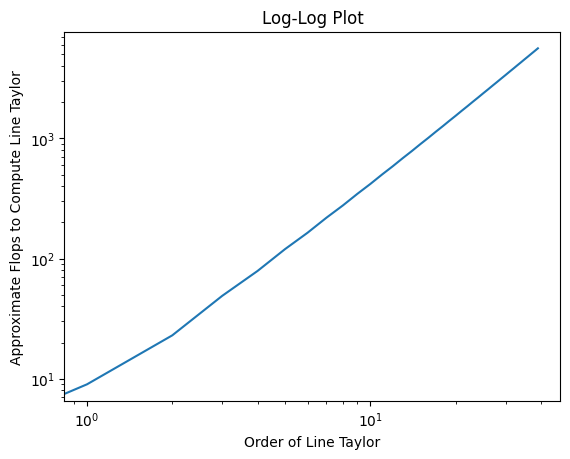

Power Fit: 1.9268617311757164


In [5]:
'''
3. ) Plot Line Taylor Flops
'''
#flops_at_order is the number of flops to take i derivatives of coeff0 with respect to tau
flops_at_order = []
flops = []

#compute flops for 10 derivatives
N = 40

# "nicer" alternative:
flops_at_order = [
    counter(sympy_derivative_then_convert(coeff0, i))
    for i in range(N)]
    
flops_at_order_np = np.array(flops_at_order)

#naively assume that the flops for a order n-taylor expansion is proportional to computing the previous
#n-derivatives
#i.e. sum elements up to index i in flops_at_order_np
for i in range(N):
    flops.append(np.sum(flops_at_order_np[:i]))

flops_np = np.array(flops)
order = np.array([i for i in range(N)])

#Plot Order vs Flops To Compute Line Taylor
import matplotlib.pyplot as plt
plt.loglog(order, flops_np)
plt.xlabel("Order of Line Taylor")
plt.ylabel("Approximate Flops to Compute Line Taylor")
plt.title("Log-Log Plot")
plt.show()

import scipy
print("Power Fit:", scipy.optimize.curve_fit(lambda t,a,b: a*t**b,  order,  flops_np,p0=(1, 1))[0][1])

In [6]:
'''
3. ) Wala-Andreas Target Specific Code

1. compute_target_specific
- computes the nth coefficient of our line taylor expansion as a sympy expression
-NOTE: I Haven't made the expression exact just proportional to the flops it takes to compute
2. compute_flops_at_order(n)
- compute the nth coefficient of our line taylor expansion and then computes the flops using pymbolic
'''

###Wala/Andreas Target Specific Expansion
##Step 1: Make arbitrary source/target variables
### PLACE CENTER AT ORIGIN  - EASY TO PERFORM A TRANSLATION TO GET HERE
source = make_sympy_vec("s", 3)
target = make_sympy_vec("t", 3)
center = make_obj_array([0, 0, 0])

#Compute Relevant Quantities
stcvec = center - source
stc_distance = (stcvec[0]**2 + stcvec[1]**2 + stcvec[2]**2)**0.5
ttcvec = center - target
ttc_distance = (ttcvec[0]**2 + ttcvec[1]**2 + ttcvec[2]**2)**0.5

#c_vec is source-target
c_vec = source - target
c = (c_vec[0]**2 + c_vec[1]**2 + c_vec[2]**2)**0.5

#Use Law of Cosines a^2 + b^2 - c^2 = 2abcos(gamma), where 
cos_gamma = (stc_distance**2 + ttc_distance**2 - c**2)/(2*stc_distance*ttc_distance)

#Compute the nth order piece of a target-specific expansion in sympy
#My expression is missing a pi 
#I am going to pretend like we are computing the first legendre polynomial to take into account the flops
#for cos_gamma, and not worry about the O(1) recurrence relation for computing legendre polynomials
def compute_target_specific(n):
    return (ttc_distance**n/stc_distance**(n+1))*sympy.legendre(1, cos_gamma)

### Compute flops at each order n by translating to pymbolic
def compute_flops_at_order(n):
    return counter(converter(compute_target_specific(n)))

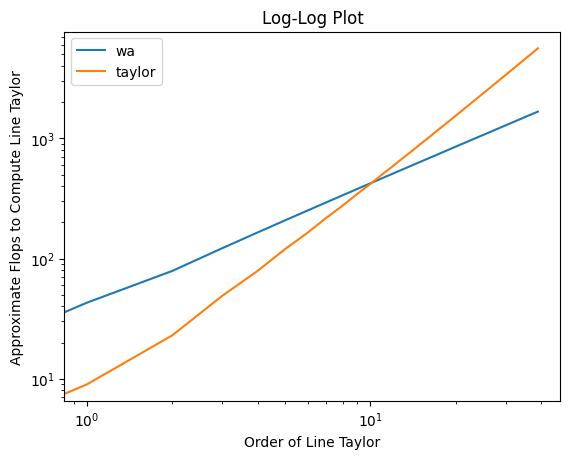

Power Fit WA: 1.009068203985075


In [7]:
#Plot Flops
#wa = wala/andreas
#compute flops for 10 derivatives
flops_at_order_wa = []
flops_wa = []

N_wa = N

# "nicer" alternative:
flops_at_order_wa = [
    compute_flops_at_order(i)
    for i in range(N)]
    
flops_at_order_np_wa = np.array(flops_at_order_wa)

#naively assume that the flops for a order n-taylor expansion is proportional to computing the previous
#n-derivatives
#i.e. sum elements up to index i in flops_at_order_np
for i in range(N):
    flops_wa.append(np.sum(flops_at_order_np_wa[:i]))

flops_np_wa = np.array(flops_wa)
order_wa = np.array([i for i in range(N)])

#Plot Order vs Flops To Compute Wala/Andreas T.S. Expansion
import matplotlib.pyplot as plt
plt.loglog(order_wa, flops_np_wa, label='wa')
plt.loglog(order, flops_np,label='taylor')
plt.legend()
plt.xlabel("Order of Line Taylor")
plt.ylabel("Approximate Flops to Compute Line Taylor")
plt.title("Log-Log Plot")
plt.show()

import scipy
print("Power Fit WA:", scipy.optimize.curve_fit(lambda t,a,b: a*t**b,  order_wa,  flops_np_wa,p0=(1, 1))[0][1])

In [8]:
'''
4. ) HOW CAN WE MAKE LINE TAYLOR COMPETITIVE?
https://arxiv.org/pdf/2305.17867.pdf
4.4.2 Laplace Recurrence Relations
'''
#Recall that we placed our source at an arbitrary -a_vec
#We placed our target at (b_0,0,0)

compute_target_specific_taylor(0)

1/sqrt(a1**2 + a2**2 + (a0 + b0*t)**2)

In [9]:
compute_target_specific_taylor(1)

-b0*(a0 + b0*t)/(a1**2 + a2**2 + (a0 + b0*t)**2)**(3/2)

In [10]:
compute_target_specific_taylor(2)

b0**2*(3*(a0 + b0*t)**2/(a1**2 + a2**2 + (a0 + b0*t)**2) - 1)/(a1**2 + a2**2 + (a0 + b0*t)**2)**(3/2)

In [11]:
compute_target_specific_taylor(3)

3*b0**3*(a0 + b0*t)*(-5*(a0 + b0*t)**2/(a1**2 + a2**2 + (a0 + b0*t)**2) + 3)/(a1**2 + a2**2 + (a0 + b0*t)**2)**(5/2)

In [12]:
compute_target_specific_taylor(4)

3*b0**4*(35*(a0 + b0*t)**4/(a1**2 + a2**2 + (a0 + b0*t)**2)**2 - 30*(a0 + b0*t)**2/(a1**2 + a2**2 + (a0 + b0*t)**2) + 3)/(a1**2 + a2**2 + (a0 + b0*t)**2)**(5/2)

In [13]:
compute_target_specific_taylor(5)

15*b0**5*(a0 + b0*t)*(-63*(a0 + b0*t)**4/(a1**2 + a2**2 + (a0 + b0*t)**2)**2 + 70*(a0 + b0*t)**2/(a1**2 + a2**2 + (a0 + b0*t)**2) - 15)/(a1**2 + a2**2 + (a0 + b0*t)**2)**(7/2)

In [14]:
compute_target_specific_taylor(6)

45*b0**6*(231*(a0 + b0*t)**6/(a1**2 + a2**2 + (a0 + b0*t)**2)**3 - 315*(a0 + b0*t)**4/(a1**2 + a2**2 + (a0 + b0*t)**2)**2 + 105*(a0 + b0*t)**2/(a1**2 + a2**2 + (a0 + b0*t)**2) - 5)/(a1**2 + a2**2 + (a0 + b0*t)**2)**(7/2)